## Assess the impact of atmosphere on offset time-seris

Run the following `prep_*.ipynb` to generate the input time-series for this analysis:
1. prep_offset.ipynb
2. prep_era5.ipynb
3. prep_gim_tec.ipynb
4. prep_igs_tec.ipynb

In [5]:
%matplotlib inline
import os
import copy
import pickle
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from mintpy.utils import plot as pp

proj_dir = os.path.expanduser('~/data/archives/ChileSenAT149')
os.chdir(proj_dir)
print('Go to directory', proj_dir)

Go to directory /Users/yunjunz/data/archives/ChileSenAT149


### read all time-series

In [6]:
# output files from prep_*.ipynb
mintpy_dir = os.path.join(proj_dir, 'mintpyOffset')
off_file = os.path.join(mintpy_dir, 'TS_offset.pickle')
gim_file = os.path.join(mintpy_dir, 'TS_gim_tec.pickle')
igs_file = os.path.join(mintpy_dir, 'TS_igs_tec.pickle')
era_file = os.path.join(mintpy_dir, 'TS_era5.pickle')

# read files into: off, gim, igs, era
dset_list = []
for fname in [off_file, gim_file, igs_file, era_file]:
    with open(fname, 'rb') as f:
        dset_list.append(pickle.load(f))
        print('read from pickle file: {}'.format(fname))
sar, gim, igs, era = dset_list

read from pickle file: /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_offset.pickle
read from pickle file: /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_gim_tec.pickle
read from pickle file: /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_igs_tec.pickle
read from pickle file: /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_era5.pickle


In [7]:
def get_common_index(dict1, dict2):
    # get common dates
    t1s = dict1['time']
    t2s = dict2['time']
    tcomm = np.array(sorted(list(set(t1s) & set(t2s))))

    flag1 = np.zeros(t1s.size, dtype=np.bool_)
    for i in range(t1s.size):
        if t1s[i] in tcomm:
            flag1[i] = True

    flag2 = np.zeros(t2s.size, dtype=np.bool_)
    for i in range(t2s.size):
        if t2s[i] in tcomm:
            flag2[i] = True

    return flag1, flag2

### SAR v.s. sub-orbital TEC

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_Sen_gim_downside.png


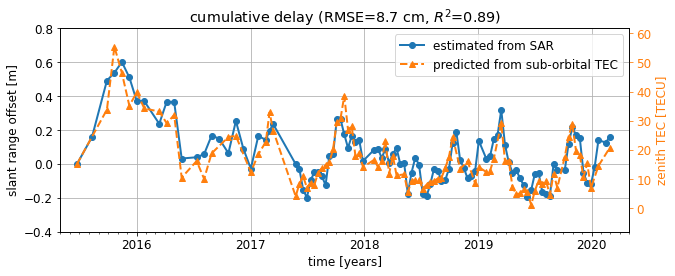

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/DOT_Sen_sar_vs_gim_downside.png


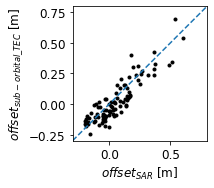

In [8]:
## data
sar['data'] = np.array(sar['range_offset_median'])            # estimated offset from SAR
gim['data'] = np.array(gim['range_delay4Cband_tec_downside']) # predicted offset from total GIM TEC
# aux info for ytick on ax2
ratio = ((np.max(gim['vtec_downside']) - 
          np.min(gim['vtec_downside'])) /
         (np.max(gim['data']) - 
          np.min(gim['data'])))
yoff = gim['data'][0]
# align the 1st value to zero
gim['data'] -= yoff

flag = get_common_index(sar, gim)[0]
rmse = np.sqrt(np.sum((gim['data'] - sar['data'][flag])**2) / (np.sum(flag) - 1))
r2 = stats.linregress(gim['data'], sar['data'][flag])[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(sar['time'], sar['data'],  '-o', label='estimated from SAR',             color='C0', ms=6, lw=2)
ax.plot(gim['time'], gim['data'], '--^', label='predicted from sub-orbital TEC', color='C1', ms=6, lw=2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.4, 0.8)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
ax.legend()
ax.grid('on')
fig.tight_layout()

# TEC ytick
ax2 = ax.twinx()
ax2.set_ylabel('zenith TEC [TECU]', color='C1')
ax2.tick_params(which='both', axis='y', colors='C1')
#ax2.plot(gim['time'], gim['vtec_downside'], '--', linewidth=1, color='C2', label='vertical TEC') # for debug
ax2.set_ylim(ymin=(ax.get_ylim()[0] + yoff) * ratio,
             ymax=(ax.get_ylim()[1] + yoff) * ratio)

# output
out_fig = os.path.join(mintpy_dir, 'TS_Sen_gim_downside.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## dot figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
ax.plot(sar['data'][flag], gim['data'], 'k.')
# aux
v0, v1 = -0.3, 0.8
ax.plot((v0, v1), (v0, v1), '--')
ax.set_xlim(v0, v1)
ax.set_ylim(v0, v1)
ax.set_xlabel('$offset_{SAR}$ [m]')
ax.set_ylabel('$offset_{sub-orbital\_TEC}$ [m]')
ax.set_aspect('equal', 'box')
fig.tight_layout()

# output
out_fig = os.path.join(mintpy_dir, 'DOT_Sen_sar_vs_gim_downside.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### SAR v.s. total TEC

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_Sen_gim_total.png


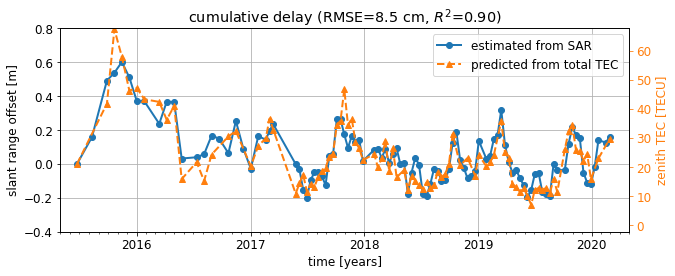

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/DOT_Sen_sar_vs_gim_total.png


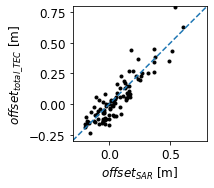

In [9]:
## data
sar['data'] = np.array(sar['range_offset_median'])         # estimated offset from SAR
gim['data'] = np.array(gim['range_delay4Cband_tec_total']) # predicted offset from total GIM TEC
# aux info for ytick on ax2
ratio = ((np.max(gim['vtec_total']) - 
          np.min(gim['vtec_total'])) /
         (np.max(gim['data']) - 
          np.min(gim['data'])))
yoff = gim['data'][0]
# align the 1st value to zero
gim['data'] -= yoff

flag = get_common_index(sar, gim)[0]
rmse = np.sqrt(np.sum((gim['data'] - sar['data'][flag])**2) / (np.sum(flag) - 1))
r2 = stats.linregress(gim['data'], sar['data'][flag])[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(sar['time'], sar['data'],  '-o', label='estimated from SAR',       color='C0', ms=6, lw=2)
ax.plot(gim['time'], gim['data'], '--^', label='predicted from total TEC', color='C1', ms=6, lw=2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.4, 0.8)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
ax.legend()
ax.grid('on')
fig.tight_layout()

# TEC ytick
ax2 = ax.twinx()
ax2.set_ylabel('zenith TEC [TECU]', color='C1')
ax2.tick_params(which='both', axis='y', colors='C1')
#ax2.plot(gim['time'], gim['vtec_downside'], '--', linewidth=1, color='C2', label='vertical TEC') # for debug
ax2.set_ylim(ymin=(ax.get_ylim()[0] + yoff) * ratio,
             ymax=(ax.get_ylim()[1] + yoff) * ratio)

# output
out_fig = os.path.join(mintpy_dir, 'TS_Sen_gim_total.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()


## dot figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
ax.plot(sar['data'][flag], gim['data'], 'k.')
# aux
v0, v1 = -0.3, 0.8
ax.plot((v0, v1), (v0, v1), '--')
ax.set_xlim(v0, v1)
ax.set_ylim(v0, v1)
ax.set_xlabel('$offset_{SAR}$ [m]')
ax.set_ylabel('$offset_{total\_TEC}$ [m]')
ax.set_aspect('equal', 'box')
fig.tight_layout()

# output
out_fig = os.path.join(mintpy_dir, 'DOT_Sen_sar_vs_gim_total.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### residual (total TEC - SAR)

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_Sen_gim_resid.png


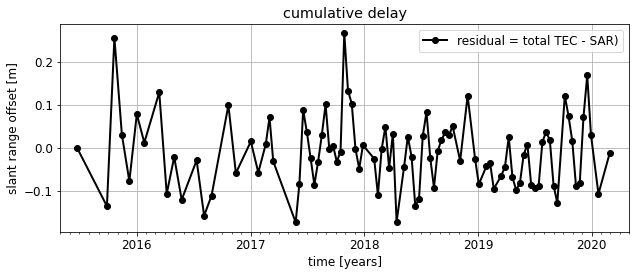

In [10]:
sar['data'] = np.array(sar['range_offset_median'])         # estimated offset from SAR
gim['data'] = np.array(gim['range_delay4Cband_tec_total']) # predicted offset from total GIM TEC
# align the 1st value to zero
gim['data'] -= gim['data'][0]

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(gim['time'], gim['data'] - sar['data'][flag], '-o', label='residual = total TEC - SAR)', color='k', ms=6, lw=2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
#ax.set_ylim(-0.4, 0.4)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay')
pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(mintpy_dir, 'TS_Sen_gim_resid.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Distance from GIM TEC obs to SAR scene center

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_Sen_gim_dist.png


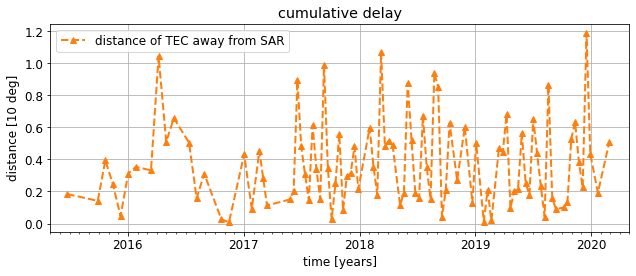

In [11]:
## plot
fig, ax = plt.subplots(figsize=[9, 4])
#ax.plot(sar['time'], sar['data'],  '-o', label='estimated offset from SAR', color='C0', ms=6, lw=2)
ax.plot(gim['time'], gim['distance']/108e4, '--^', label='distance of TEC away from SAR', color='C1', ms=6, lw=2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
#ax.set_ylim(-0.4, 0.4)
ax.set_xlabel('time [years]')
ax.set_ylabel('distance [10 deg]')
ax.set_title('cumulative delay')
pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(mintpy_dir, 'TS_Sen_gim_dist.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### residual vs tropo

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_Sen_resid_vs_era.png


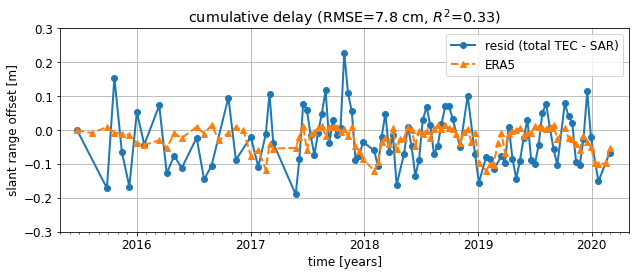

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/DOT_Sen_resid_vs_era.png


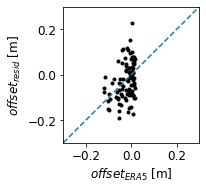

In [12]:
## data
sar['data'] = np.array(sar['range_offset_median'])            # estimated offset from SAR
gim['data'] = np.array(gim['range_delay4Cband_tec_downside']) # predicted offset from total GIM TEC
era['data'] = np.array(era['range_delay_tropo_median'])       # predicted offset from ERA5 (dry + wet)
gim['data'] -= gim['data'][0]
era['data'] -= era['data'][0]

flag = get_common_index(sar, gim)[0]
resid = gim['data'] - sar['data'][flag]
rmse = np.sqrt(np.sum((era['data'][flag] - resid)**2) / (np.sum(flag) - 1))
r2 = stats.linregress(era['data'][flag], resid)[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(gim['time'], resid,        '-o', label='resid (total TEC - SAR)', color='C0', ms=6, lw=2)
ax.plot(era['time'], era['data'], '--^', label='ERA5',                    color='C1', ms=6, lw=2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(mintpy_dir, 'TS_Sen_resid_vs_era.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## dot figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
ax.plot(era['data'][flag], resid, 'k.')
# aux
v0, v1 = -0.3, 0.3
ax.plot((v0, v1), (v0, v1), '--')
ax.set_xlim(v0, v1)
ax.set_ylim(v0, v1)
ax.set_xlabel('$offset_{ERA5}$ [m]')
ax.set_ylabel('$offset_{resid}$ [m]')
ax.set_aspect('equal', 'box')
fig.tight_layout()
# output
out_fig = os.path.join(mintpy_dir, 'DOT_Sen_resid_vs_era.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### SAR v.s. IGS TEC

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/TS_Sen_igs.png


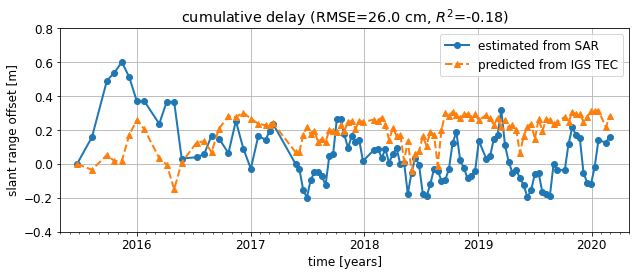

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/DOT_Sen_igs.png


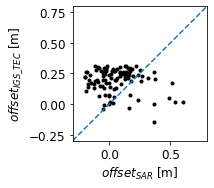

In [14]:
## data
sar['data'] = np.array(sar['range_offset_median'])  # estimated offset from SAR
igs['data'] = np.array(igs['range_delay'])          # predicted offset from total GIM TEC
# align the 1st value to zero
igs['data'] *= -1
igs['data'] -= igs['data'][0]

#flag = get_common_index(sar, igs)[0]
rmse = np.sqrt(np.sum((igs['data'] - sar['data'])**2) / (np.sum(flag) - 1))
r2 = stats.linregress(igs['data'], sar['data'])[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.plot(sar['time'], sar['data'],  '-o', label='estimated from SAR',     color='C0', ms=6, lw=2)
ax.plot(igs['time'], igs['data'], '--^', label='predicted from IGS TEC', color='C1', ms=6, lw=2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.4, 0.8)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(mintpy_dir, 'TS_Sen_igs.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## dot figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
ax.plot(sar['data'], igs['data'], 'k.')
# aux
v0, v1 = -0.3, 0.8
ax.plot((v0, v1), (v0, v1), '--')
ax.set_xlim(v0, v1)
ax.set_ylim(v0, v1)
ax.set_xlabel('$offset_{SAR}$ [m]')
ax.set_ylabel('$offset_{IGS\_TEC}$ [m]')
ax.set_aspect('equal', 'box')
fig.tight_layout()
# output
out_fig = os.path.join(mintpy_dir, 'DOT_Sen_igs.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### predicted impact on L-band

save figure to file /Users/yunjunz/data/archives/ChileSenAT149/mintpyOffset/pred_gim_off.png


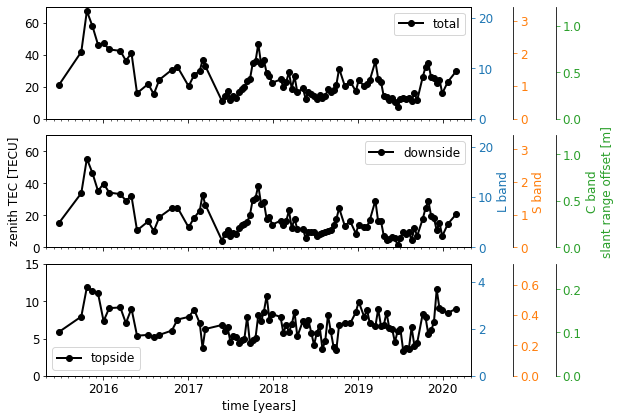

In [68]:
## data
sides = ['total', 'downside', 'topside']
bands = ['Cband', 'Sband', 'Lband']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 6], sharex=True)
for i in range(len(sides)):
    side = sides[i]
    key_tec = 'vtec_{s}'.format(s=side)

    ## plot
    ax = axs[i]
    ax.plot(gim['time'], gim[key_tec], '-o', label=side, color='k', ms=6, lw=2)

    # axis format
    if i in [0, 1]:
        ax.set_ylim(0, 70)
    else:
        ax.set_ylim(0, 15)
    ax.legend()
    #ax.grid('on')

    # TEC ytick
    colors = ['C0', 'C1', 'C2']
    for j in range(len(bands)):
        band = bands[2-j]
        key_off = 'range_delay4{b}_tec_{s}'.format(b=band, s=side)
        pos = 1.0 + 0.1 * j
        c = colors[j]
        label = '{} band'.format(band.split('band')[0])
        if j == 2:
            label += '\nslant range offset [m]'

        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', pos))
        ax2.tick_params(which='both', axis='y', colors=c)

        ratio = ((np.max(gim[key_off]) - np.min(gim[key_off])) /
                 (np.max(gim[key_tec]) - np.min(gim[key_tec])))
        ax2.set_ylim(ymin=ax.get_ylim()[0] * ratio,
                     ymax=ax.get_ylim()[1] * ratio)

        if i == 1:
            ax2.set_ylabel(label, color=c)


axs[1].set_ylabel('zenith TEC [TECU]')
pp.auto_adjust_xaxis_date(axs[-1], sar['time'], every_year=1, buffer_year=None)
axs[-1].set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
axs[-1].set_xlabel('time [years]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# output
out_fig = os.path.join(mintpy_dir, 'pred_gim_off.png'.format(side))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()